RECUPERATION DES DONNEES

In [4]:
import pandas as pd
from matplotlib import pyplot as plt
import os
import geopandas as gpd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import seaborn as sns
from shapely.geometry import Point

In [5]:
path = "CSV_data/METEOFRANCE"

df_meteo_month = []

for year in range(2020, 2024):  
    for month in range(1, 13):  
        date = f"{year}{month:02d}"  # Format "202001", "202002", etc
        file_name = f"synop.{date}.csv.gz"
        file_path = os.path.join(path, file_name)
        try:
            df = pd.read_csv(file_path, compression='gzip', sep=';', encoding='utf-8')
            df_meteo_month.append(df)  # Ajouter chaque DataFrame à la liste
        except FileNotFoundError:
            print(f"Fichier non trouvé : {file_path}")
        except Exception as e:
            print(f"Erreur lors du chargement de {file_path} : {e}")

df_meteo = pd.concat(df_meteo_month, ignore_index=True)

print(df_meteo.head())

   numer_sta            date    pmer tend cod_tend   dd        ff           t  \
0       7005  20200101000000  103180  -80        8  120  1.800000  274.350000   
1       7015  20200101000000  103320    0        5   80  4.700000  275.250000   
2       7020  20200101000000  102870  -70        8   80  1.300000  280.550000   
3       7027  20200101000000  103080    0        0  100  4.200000  275.750000   
4       7037  20200101000000  103190  -30        8  130  2.200000  272.250000   

           td    u  ... nnuage2 ctype2 hnuage2 nnuage3 ctype3 hnuage3 nnuage4  \
0  272.750000   89  ...      mq     mq      mq      mq     mq      mq      mq   
1  275.150000   99  ...      mq     mq      mq      mq     mq      mq      mq   
2  279.450000   93  ...      mq     mq      mq      mq     mq      mq      mq   
3  275.750000  100  ...      mq     mq      mq      mq     mq      mq      mq   
4  272.250000  100  ...      mq     mq      mq      mq     mq      mq      mq   

  ctype4 hnuage4 Unnamed: 

In [6]:
print(df_meteo.columns)

Index(['numer_sta', 'date', 'pmer', 'tend', 'cod_tend', 'dd', 'ff', 't', 'td',
       'u', 'vv', 'ww', 'w1', 'w2', 'n', 'nbas', 'hbas', 'cl', 'cm', 'ch',
       'pres', 'niv_bar', 'geop', 'tend24', 'tn12', 'tn24', 'tx12', 'tx24',
       'tminsol', 'sw', 'tw', 'raf10', 'rafper', 'per', 'etat_sol', 'ht_neige',
       'ssfrai', 'perssfrai', 'rr1', 'rr3', 'rr6', 'rr12', 'rr24', 'phenspe1',
       'phenspe2', 'phenspe3', 'phenspe4', 'nnuage1', 'ctype1', 'hnuage1',
       'nnuage2', 'ctype2', 'hnuage2', 'nnuage3', 'ctype3', 'hnuage3',
       'nnuage4', 'ctype4', 'hnuage4', 'Unnamed: 59'],
      dtype='object')


In [7]:
colonnes_a_garder = ['numer_sta', 'date', 'pmer', 'tend', 'dd', 'ff', 't', 'u', 'vv', 'rr24']
noms_colonnes = {
    'numer_sta': 'ID',
    'date': 'date_UTC',
    'pmer': 'pression_niveau_mer_Pa',
    'tend': 'var_pression_3h_Pa',
    'dd': 'direction_vent_moyen_10mn_deg',
    'ff': 'vitesse_vent_moyen_10mn_m/s',
    't': 'temperature_K',
    'u': 'humidite_%',
    'vv': 'visibilite_horizontale_m',
    'rr24': 'precipitations_24h_mm'
}

df_meteo = df_meteo[colonnes_a_garder]
df_meteo = df_meteo.rename(columns=noms_colonnes)


In [8]:
def filtre_mesure_minuit(df):
    # Convertir la colonne date_UTC au format datetime
    df['date_UTC'] = pd.to_datetime(df['date_UTC'], format='%Y%m%d%H%M%S', errors='coerce')
    
    # Filtrer les lignes correspondant à minuit (heure, minute et seconde égales à 0)
    df_minuit = df[(df['date_UTC'].dt.hour == 0) & 
                   (df['date_UTC'].dt.minute == 0) & 
                   (df['date_UTC'].dt.second == 0)]
    
    return df_minuit

# Appliquer cette fonction de filtrage 
df_meteo = filtre_mesure_minuit(df_meteo)  # Garder seulement les mesures à minuit
df_meteo['date_UTC'] = df_meteo['date_UTC'].dt.strftime('%Y-%m-%d')

print(df_meteo.head())


     ID    date_UTC pression_niveau_mer_Pa var_pression_3h_Pa  \
0  7005  2020-01-01                 103180                -80   
1  7015  2020-01-01                 103320                  0   
2  7020  2020-01-01                 102870                -70   
3  7027  2020-01-01                 103080                  0   
4  7037  2020-01-01                 103190                -30   

  direction_vent_moyen_10mn_deg vitesse_vent_moyen_10mn_m/s temperature_K  \
0                           120                    1.800000    274.350000   
1                            80                    4.700000    275.250000   
2                            80                    1.300000    280.550000   
3                           100                    4.200000    275.750000   
4                           130                    2.200000    272.250000   

  humidite_% visibilite_horizontale_m precipitations_24h_mm  
0         89                     9290             -0.100000  
1         99          

In [9]:
path = "CSV_data/METEOFRANCE/postesSynop.json"
stations_gdf = gpd.read_file(path)
print(stations_gdf.head())
print(stations_gdf.crs)


      ID              Nom   Latitude  Longitude Altitude  \
0  07005        ABBEVILLE  50.136000   1.834000       69   
1  07015    LILLE-LESQUIN  50.570000   3.097500       47   
2  07020  PTE DE LA HAGUE  49.725167  -1.939833        6   
3  07027   CAEN-CARPIQUET  49.180000  -0.456167       67   
4  07037       ROUEN-BOOS  49.383000   1.181667      151   

                    geometry  
0       POINT (1.834 50.136)  
1       POINT (3.0975 50.57)  
2  POINT (-1.93983 49.72517)  
3     POINT (-0.45617 49.18)  
4     POINT (1.18167 49.383)  
EPSG:4326


In [10]:
stations_df = pd.DataFrame(stations_gdf)
print(stations_df['Longitude'].dtype)

#On doit convertir les données des colonnes longitude et latitude en données numériques pour pouvoir les plotter
stations_df['Longitude'] = pd.to_numeric(stations_df['Longitude'], errors='coerce')
stations_df['Latitude'] = pd.to_numeric(stations_df['Latitude'], errors='coerce')

print(stations_df.head())

object
      ID              Nom   Latitude  Longitude Altitude  \
0  07005        ABBEVILLE  50.136000   1.834000       69   
1  07015    LILLE-LESQUIN  50.570000   3.097500       47   
2  07020  PTE DE LA HAGUE  49.725167  -1.939833        6   
3  07027   CAEN-CARPIQUET  49.180000  -0.456167       67   
4  07037       ROUEN-BOOS  49.383000   1.181667      151   

                    geometry  
0       POINT (1.834 50.136)  
1       POINT (3.0975 50.57)  
2  POINT (-1.93983 49.72517)  
3     POINT (-0.45617 49.18)  
4     POINT (1.18167 49.383)  


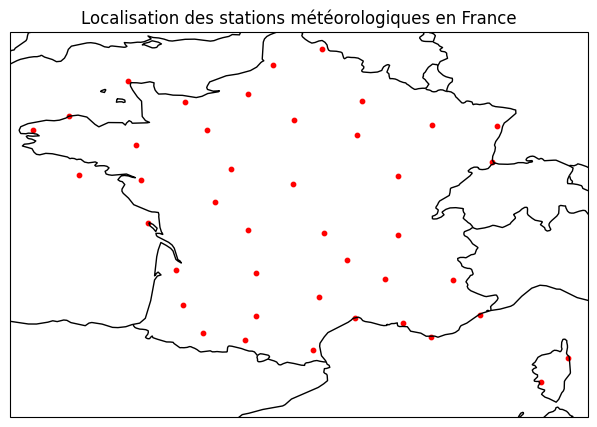

In [11]:
# Créer la figure
fig = plt.figure(figsize=(9, 5))

# Sélectionner une projection pour la carte
ax = plt.axes(projection=ccrs.PlateCarree())

# Tracer les stations avec leurs coordonnées (lon, lat) de toutes les stations
scatter = ax.scatter(stations_df['Longitude'], stations_df['Latitude'], color='red', s=10, label='Stations')

# Ajouter les éléments géographiques : côtes et frontières
ax.coastlines(resolution='50m', linewidth=1)
ax.add_feature(cfeature.BORDERS.with_scale('50m'))

# Définir la région à afficher pour toute la France
ax.set_extent([-5, 10, 41, 51])  # Coordonnées approximatives pour toute la France

# Ajouter un titre à la carte
plt.title("Localisation des stations météorologiques en France")

# Afficher la carte
plt.show()

In [24]:
stations_df['ID'] = pd.to_numeric(stations_df['ID'], errors='coerce')
df_meteo_tot = pd.merge(df_meteo, stations_df, how='left', on='ID')
df_meteo_tot = df_meteo_tot.drop(['Altitude'], axis=1)
print(df_meteo_tot.head())


     ID    date_UTC pression_niveau_mer_Pa var_pression_3h_Pa  \
0  7005  2020-01-01                 103180                -80   
1  7015  2020-01-01                 103320                  0   
2  7020  2020-01-01                 102870                -70   
3  7027  2020-01-01                 103080                  0   
4  7037  2020-01-01                 103190                -30   

  direction_vent_moyen_10mn_deg vitesse_vent_moyen_10mn_m/s temperature_K  \
0                           120                    1.800000    274.350000   
1                            80                    4.700000    275.250000   
2                            80                    1.300000    280.550000   
3                           100                    4.200000    275.750000   
4                           130                    2.200000    272.250000   

  humidite_% visibilite_horizontale_m precipitations_24h_mm              Nom  \
0         89                     9290             -0.100000       

In [13]:
colonnes_a_exclure = ['date_UTC', 'Latitude', 'Longitude','Nom']

# Sélectionner toutes les colonnes sauf celles à exclure 
colonnes_a_convertir = [col for col in df_meteo_tot.columns if col not in colonnes_a_exclure]

# Appliquer la conversion en numérique à toutes les colonnes sélectionnées (pour pouvoir décrire les données)
df_meteo_tot[colonnes_a_convertir] = df_meteo_tot[colonnes_a_convertir].apply(pd.to_numeric, errors='coerce')
df_meteo_tot['date_UTC'] = pd.to_datetime(df_meteo_tot['date_UTC'], errors='coerce')

df_meteo_tot['temperature_C'] = df_meteo_tot['temperature_K'] - 273.15
df_meteo_tot = df_meteo_tot.drop('temperature_K',axis=1)


ANALYSE DES DONNEES

In [14]:
print(df_meteo_tot.shape)

(86772, 14)


In [15]:
colonnes_a_etudier = ['pression_niveau_mer_Pa', 'var_pression_3h_Pa', 'direction_vent_moyen_10mn_deg', 'vitesse_vent_moyen_10mn_m/s', 'temperature_C', 'humidite_%', 'visibilite_horizontale_m', 'precipitations_24h_mm']
print(df_meteo_tot[colonnes_a_etudier].describe())

       pression_niveau_mer_Pa  var_pression_3h_Pa  \
count            81278.000000        84599.000000   
mean            101608.598883           25.371104   
std                899.022990          124.397644   
min              94120.000000        -1410.000000   
25%             101210.000000          -50.000000   
50%             101620.000000           20.000000   
75%             102120.000000          110.000000   
max             104890.000000         1310.000000   

       direction_vent_moyen_10mn_deg  vitesse_vent_moyen_10mn_m/s  \
count                   85867.000000                 85874.000000   
mean                      172.927201                     3.776962   
std                       105.578838                     3.191799   
min                         0.000000                     0.000000   
25%                        80.000000                     1.600000   
50%                       170.000000                     2.900000   
75%                       260.000000   

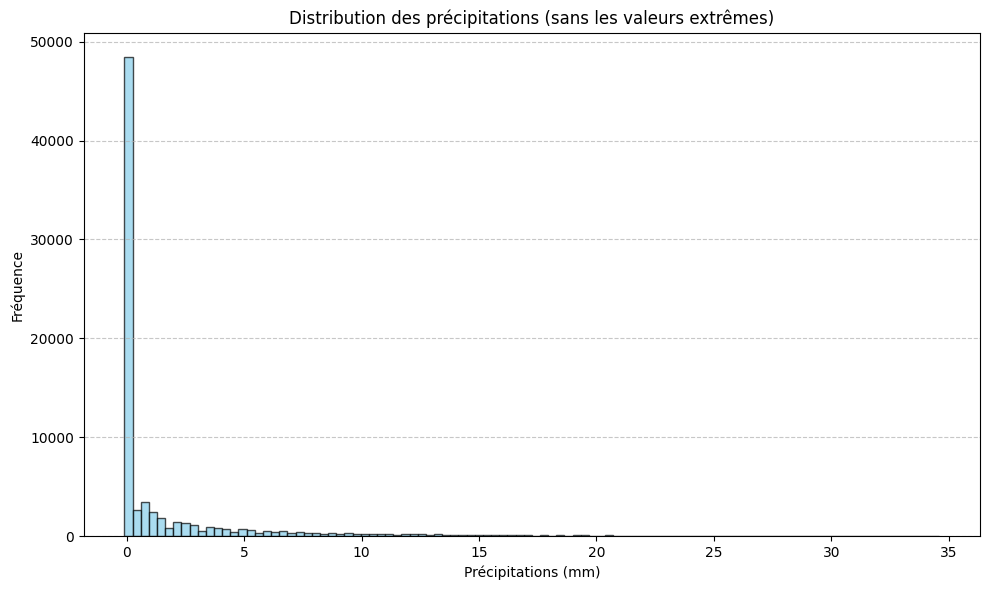

In [16]:
# Calcul du seuil d'outlier (99e percentile)
threshold = df_meteo_tot['precipitations_24h_mm'].quantile(0.99)

# Filtrer les données pour les précipitations < seuil
df_filtered = df_meteo_tot[df_meteo_tot['precipitations_24h_mm'] <= threshold]

plt.figure(figsize=(10, 6))
plt.hist(df_filtered['precipitations_24h_mm'], bins=100, color='skyblue', edgecolor='black', alpha=0.7)
plt.title("Distribution des précipitations (sans les valeurs extrêmes)")
plt.xlabel("Précipitations (mm)")
plt.ylabel("Fréquence")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


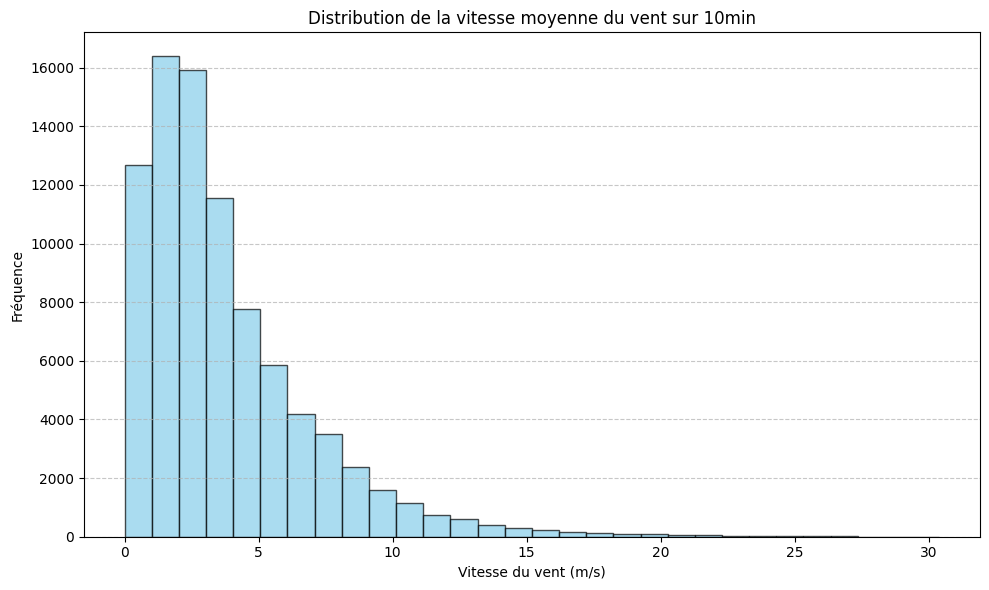

In [17]:
plt.figure(figsize=(10, 6))

# Tracer un histogramme de la colonne des précipitations
plt.hist(df_meteo_tot['vitesse_vent_moyen_10mn_m/s'], bins=30, color='skyblue', edgecolor='black', alpha=0.7)

# Ajouter des labels et un titre
plt.title("Distribution de la vitesse moyenne du vent sur 10min")
plt.xlabel("Vitesse du vent (m/s)")
plt.ylabel("Fréquence")

# Afficher le graphe
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


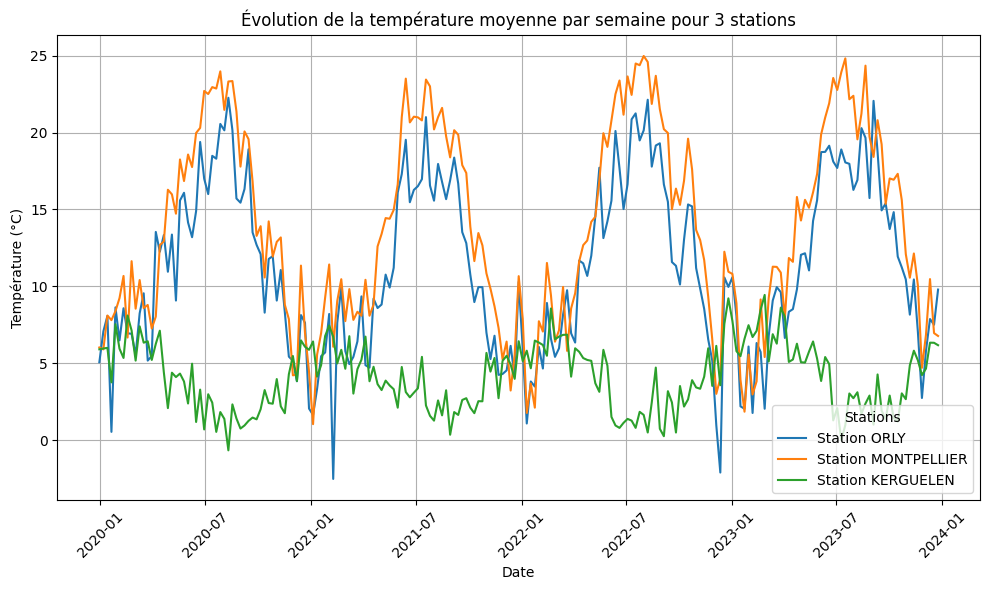

In [18]:
stations_choisies = ['ORLY', 'MONTPELLIER','KERGUELEN']

# Filtrer les données pour ces trois stations
df_stations = df_meteo_tot[df_meteo_tot['Nom'].isin(stations_choisies)]
df_stations = df_stations.copy()  

# Créer une colonne 'week' pour obtenir la semaine
df_stations['week'] = df_stations['date_UTC'].dt.to_period('W')

# Calculer la température moyenne par semaine pour chaque station
df_weekly_temp = df_stations.groupby(['Nom', 'week'])['temperature_C'].mean().reset_index()

# Tracer l'évolution de la température par semaine pour chaque station
plt.figure(figsize=(10, 6))

for station in stations_choisies:
    station_temp = df_weekly_temp[df_weekly_temp['Nom'] == station]
    plt.plot(station_temp['week'].dt.start_time, station_temp['temperature_C'], label=f"Station {station}")

# Ajouter des labels et un titre
plt.title("Évolution de la température moyenne par semaine pour 3 stations")
plt.xlabel("Date")
plt.ylabel("Température (°C)")
plt.legend(title="Stations")

# Afficher le graphe
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

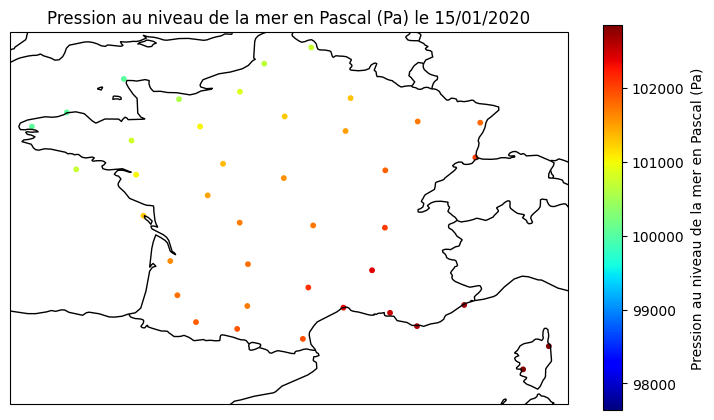

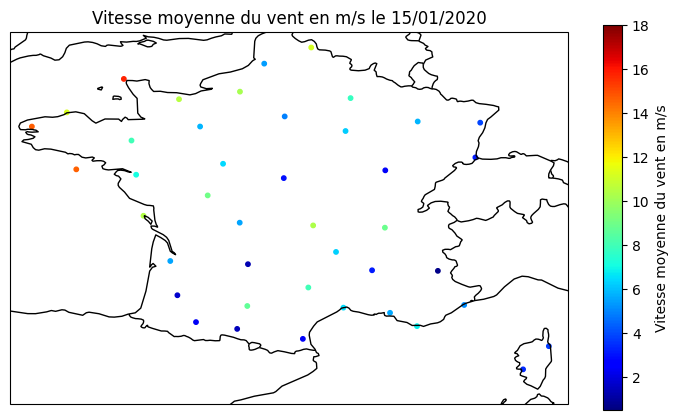

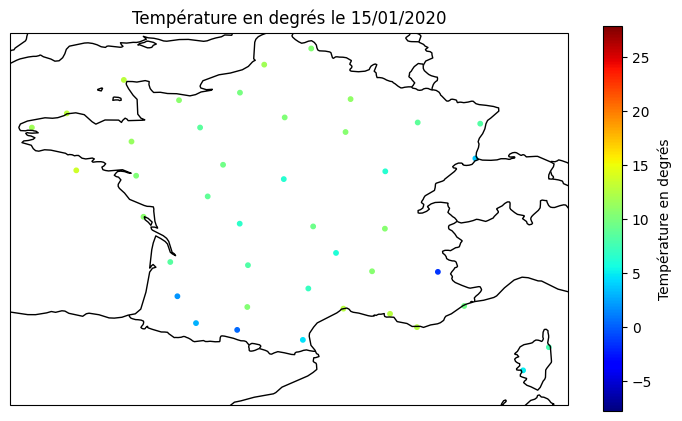

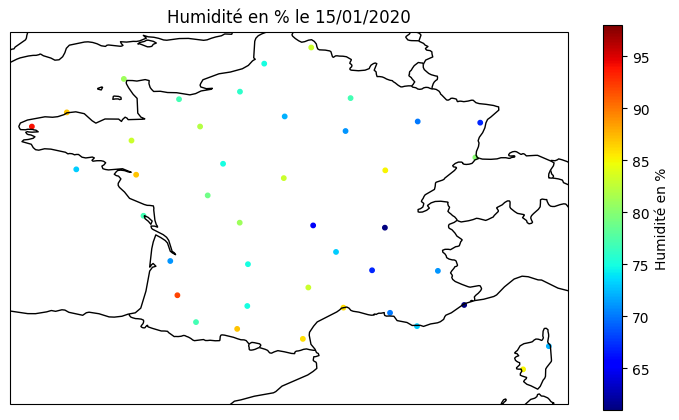

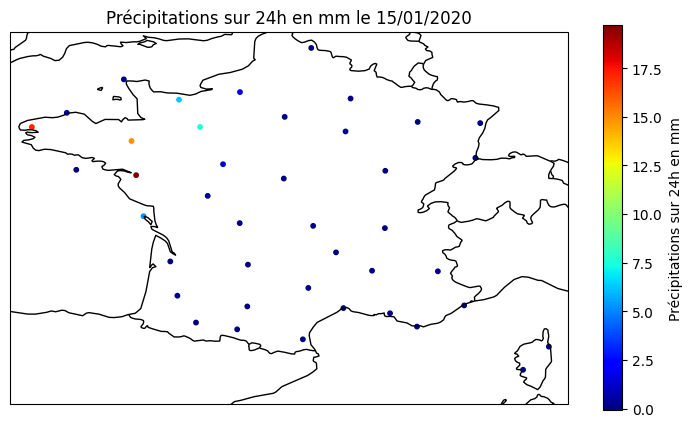

In [19]:
date_specifique = "20200115"  # sous forme 'YYYYMMDD'

# Dictionnaire des paramètres à afficher
dict_param = {
    'pression_niveau_mer_Pa': ['Pression au niveau de la mer', 'Pascal (Pa)'],  
    'vitesse_vent_moyen_10mn_m/s': ['Vitesse moyenne du vent', 'm/s'], 
    'temperature_C': ['Température', 'degrés'], 
    'humidite_%': ['Humidité', '%'], 
    'precipitations_24h_mm': ['Précipitations sur 24h', 'mm']
} 

# Boucle sur tous les paramètres
for param in dict_param.keys(): 
    nom_param, unite = dict_param[param]
    
    # Filtrer les données pour le jour spécifique
    df = df_meteo_tot[df_meteo_tot['date_UTC'] == date_specifique]

    # Créer la figure
    fig = plt.figure(figsize=(9,5))

    # Sélectionner une projection pour la carte
    ax = plt.axes(projection=ccrs.PlateCarree())

    # Scatter plot des stations avec les coordonnées (Longitude, Latitude)
    scatter = ax.scatter(df['Longitude'], df['Latitude'], c=df[param], cmap='jet', s=10)

    # Ajouter les éléments géographiques : côtes et frontières
    ax.coastlines(resolution='50m', linewidth=1)
    ax.add_feature(cfeature.BORDERS.with_scale('50m'))

    # Ajouter la barre de couleur
    cbar = plt.colorbar(scatter)
    cbar.set_label(f'{nom_param} en {unite}')  # Légende pour la barre de couleur

    # Définir la région à afficher pour toute la France
    ax.set_extent([-5, 10, 41, 51])  # Coordonnées approximatives pour toute la France

    # Ajouter un titre à la carte
    plt.title(f"{nom_param} en {unite} le {date_specifique[6:8]}/{date_specifique[4:6]}/{date_specifique[0:4]}")

    # Afficher la carte
    plt.show()



La qualité de l'air est devenue une question de santé publique majeure, avec des effets directs sur la santé des populations et des écosystèmes. En effet, selon l'Organisation Mondiale de la Santé (OMS), la pollution de l'air est responsable de millions de décès prématurés chaque année, en particulier dans les zones urbaines à forte densité de population. Cette pollution est exacerbée par des facteurs tels que les émissions de gaz à effet de serre (GES) et les conditions climatiques locales, qui modulent la concentration et la dispersion des polluants.

L'impact de la qualité de l'air est également influencé par des facteurs démographiques : une population dense et une urbanisation rapide peuvent augmenter les sources de pollution, tandis que les conditions météorologiques, comme les inversions thermiques, peuvent piéger les polluants près du sol. Face à cette problématique, il devient crucial de comprendre les interactions entre ces différents facteurs pour anticiper les périodes de pollution et prendre des mesures préventives.

Le projet que nous proposons a pour objectif de prédire la qualité de l'air dans plusieurs régions, en prenant en compte non seulement les conditions climatiques, mais aussi les caractéristiques de la population et les données d'émissions de GES. En combinant ces informations, nous visons à développer un modèle prédictif permettant d'anticiper les niveaux de pollution de l'air et ainsi de contribuer à l'élaboration de politiques publiques plus efficaces en matière de gestion de l'air et de la santé.